In [33]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import io
import requests
from zipfile import ZipFile
import re
from tensorflow.python.framework import ops, graph_util
ops.reset_default_graph()

Now , we are starting a new graph session and setting up the RNN model params.
- We are running the model through 10 epochs 
- Batch size is of 250
- The maximum length of each text will be 25; i.e. we will pad shorter sequences or cut longer texts
- the rnn size will be of 10 units i.e. there will be 10 neurons of RNN in each layer we make.
- We will only consider words that appear atleast 10 times in the vocab, to improve the training.
- Every word will be embedded into a trainable vector of size 50
- the dropout rate will be a tf placeholder which we can set to 0.5 during training or 1.0 during evaluation

In [3]:
# Start a graph
sess = tf.Session()

# Set RNN parameters
epochs = 150
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)


Now we get the text and training data. We get this data from -
- [https://www.kaggle.com/uciml/sms-spam-collection-dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)
- [http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip](http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip)

In [4]:
# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [5]:
text_data_train[:10]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n',
 'Ok lar... Joking wif u oni...\n',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n",
 'U dun say so early hor... U c already then say...\n',
 "Nah I don't think he goes to usf, he lives around here though\n",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, 1.50 to rcv\n",
 'Even my brother is not like to speak with me. They treat me like aids patent.\n',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune\n",
 'WINNER!! As a valued network customer you have been selected to receivea 900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours onl

In [6]:
text_data_target[:10]

['ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'spam']

Next important step is to clean the data, i.e. removing white space , special chars and converting everything to lowercase.

In [7]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string


clean_text(text_data_train[10])

'im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today'

Now we convert the text into appropriate list of indices.

In [8]:
# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]
text_data_train[:10]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though',
 'freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send to rcv',
 'even my brother is not like to speak with me they treat me like aids patent',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea prize reward to claim call claim code kl valid hours only',
 'had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mobil

In [9]:
# Change texts into numeric vectors
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

vocab_size = len(vocab_processor.vocabulary_)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [10]:
text_processed[:10]

array([[ 44, 455,   0, 809, 703, 667,  62,   9,   0,  87, 120, 366,   0,
        152,   0,   0,  66,  56,   0, 136,   0,   0,   0,   0,   0],
       [ 47, 315,   0, 458,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 46, 465,   9,   4, 773, 882,   1, 178,   0,   0, 622,   0, 236,
        258,  69,   0,   1,   1, 318, 465,   0,  77,   0, 368,   0],
       [  6, 230, 140,  23, 357,   0,   6, 155, 142,  58, 140,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,  42,  97,  70, 466,   1, 928,  70,   0, 202, 110, 473,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [845, 121,  66,   0,  40,  98, 611,  21,   7,  37, 353,  85, 342,
         54, 106, 387,   3,  41,  12,  14,  84,   0,  47, 340,   0],
       [196,  11, 590,   8,  24,  54,   1, 363,  35,  10, 107, 691,  10,
         54,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

Now , we need to shuffle the data to randomize it , so that the model training could be more efficient. We also convert the ham and spam words into integers so that they can be fed into the model to train.

In [11]:
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]


In [12]:
print(x_shuffled[:10])
print(y_shuffled[:10])

[[ 28   3  29 532   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [121   0  49 319 165 332  27   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [362  67   1 182  41 123   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [501   6  41   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [141 351   0  25   0 148  73   1   0  14   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  2 249  79  25 384  28  30   0   4  24 136   6 151  21   0   0   0   0
    0   0   0   0   0   0   0]
 [  0 430  24   0   3  53  11   0 847   0   3   1  13   0   0  11   0   7
    0  13 597   1  14  42 623]
 [589  69  10  43 234   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [104 190  12 479  33  14   0   0   1 101 815   9   5 201 373  80   4   0
    0   0   0   0   0   0   0]
 [  0 269  24 667   0   0   0   0   0   0   0   0   0  

In [13]:
print(len(text_data_train))
print(len(text_data_target))
print(len(x_shuffled), len(y_shuffled))

5574
5574
5574 5574


In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size = 0.2)

In [15]:
print(x_train[:10])
print(y_train[:10])

[[ 91  10 190 130 470   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  2  59 219 145   3 177  25   2  97  40  27   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 22 598  11 328  21   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0 475  41 350 167   0   3 305  39  63  35 551  15   0 195 716   0   0
    0   0   0   0   0   0   0]
 [ 81   2 102  69 154 570   0  80   3   9   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  3  17 179   4 246 174  26   4   0 114 696 138  16  86 217 214   0  18
    0   0   0   0   0   0   0]
 [  6  17   4 727   0 118   8 415 131 186  35   0  50 118 107   0 118 769
   31  23   0  18   0   0   0]
 [ 22  24 183   2  59  36 880  50  52  59   0 202   5 777   0   0   0   0
    0   0   0   0   0   0   0]
 [269   0  21  77 341  26   0  31 242 563 840 341   0   1   1 445   7  30
    0   0   0   0   0   0   0]
 [  0 296  35   4 321   0 162 173  31 252 161  25  42 1

Now we declare the placeholders for the x and y input .
x_input would be of the size = (None, max_seq_length) , since none is the batch size and every text is formatted into length of 25 .
y_input would just be either 1 or 0 for ham or spam.

In [16]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

Now , we are creating an embedding matrix and embedding lookup table for x_data.

In [17]:
## So first we create a variable of an uniformly distributed matrix of the shape vocab_size rows and embedding_size columns
## between the range -1.0 to 1.0
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
## So the embedding_matrix would be of the shape (67,50)
## then we create a lookup table that is , we make the x_data into a vector matrix.
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [18]:
print(vocab_size)

933


Now , first we specify the rnn cell we want to use , i.e. basic rnn cell or lstm or gru,
then we create the rnn sequence making it a dynamic rnn, and then add dropout to it.

In [19]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size, reuse=tf.AUTO_REUSE)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

dynamic RNN allows for variable length sequences. Even though we are using a fixed sequence length in this example, it is usually preferred to use dynamic_rnn in TensorFlow for two main reasons. One reason is that, in practice, the dynamic RNN actually runs computationally faster; the second is that, if we choose, we can run sequences of different lengths through the RNN.

Now in order to get the output, we need to rearange the RNN and slice of the last output.

In [20]:
# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

tf.gather slices of the input based on the indices.
i.e. if the input is [p1, p2, p3, p4] and we want to slice it based on the indices [0,2,1] then the output will be [p1, p3, p2]

Now to finish the RNN we need to convert the output from rnn_size to 2 cateogary output i.e. spam or ham .
this is done via a fully connected network

In [21]:
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

Now we make the loss function .


In [22]:
# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

Now we make the accuray and optimization functions.

In [23]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

C:\Users\Divyansh\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Now we can start the traning the model. We will also be shuffling the data on every step.

In [24]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.66, Test Acc: 0.84
Epoch: 2, Test Loss: 0.62, Test Acc: 0.85
Epoch: 3, Test Loss: 0.57, Test Acc: 0.85
Epoch: 4, Test Loss: 0.52, Test Acc: 0.85
Epoch: 5, Test Loss: 0.47, Test Acc: 0.86
Epoch: 6, Test Loss: 0.43, Test Acc: 0.86
Epoch: 7, Test Loss: 0.41, Test Acc: 0.87
Epoch: 8, Test Loss: 0.39, Test Acc: 0.87
Epoch: 9, Test Loss: 0.38, Test Acc: 0.87
Epoch: 10, Test Loss: 0.37, Test Acc: 0.88
Epoch: 11, Test Loss: 0.36, Test Acc: 0.88
Epoch: 12, Test Loss: 0.36, Test Acc: 0.88
Epoch: 13, Test Loss: 0.36, Test Acc: 0.88
Epoch: 14, Test Loss: 0.35, Test Acc: 0.89
Epoch: 15, Test Loss: 0.35, Test Acc: 0.89
Epoch: 16, Test Loss: 0.35, Test Acc: 0.89
Epoch: 17, Test Loss: 0.34, Test Acc: 0.89
Epoch: 18, Test Loss: 0.31, Test Acc: 0.9
Epoch: 19, Test Loss: 0.27, Test Acc: 0.91
Epoch: 20, Test Loss: 0.27, Test Acc: 0.91
Epoch: 21, Test Loss: 0.24, Test Acc: 0.94
Epoch: 22, Test Loss: 0.22, Test Acc: 0.94
Epoch: 23, Test Loss: 0.21, Test Acc: 0.94
Epoch: 24, Test Loss:

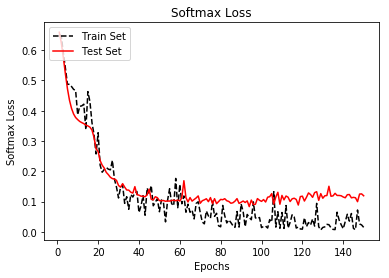

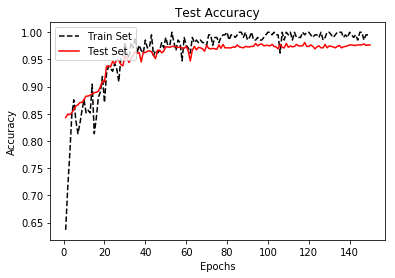

In [25]:
# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [35]:
output_node_names = "not_activated_output,output"
output_graph_def = graph_util.convert_variables_to_constants(
    sess,                                               # We need to pass session object, it contains all variables
    tf.get_default_graph().as_graph_def(),              # also graph definition is necessary
    output_node_names.split(",")                        # we may use multiple nodes for output
)
model_file = "./saved_model.pb"
with tf.gfile.GFile(model_file, "wb") as f:
    f.write(output_graph_def.SerializeToString()) 

AssertionError: not_activated_output is not in graph